In [1]:
#import module (library)

import pandas as pd
import pycaret
import numpy as np
import math
import matplotlib.pyplot as plt
from pycaret.regression import *

from pycaret.regression import load_model

import plotly.io as pio
pio.renderers.default = 'iframe_connected'

import time

In [2]:
# import module (user defined function)

from py_module.load_data import load_data
from py_module.plot_data import plot_histogram
from py_module.regression import regression_basic
from py_module.pre_processing import *
from py_module.verify import *

In [3]:
# import raw_data (from csv file)

filename = "./Data_2021_10_14_v1 (N98923)/Data.csv" # csv file directory and name

raw_data = load_data(fn=filename, pp=1)


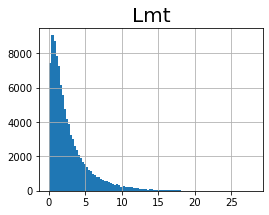

In [4]:
# plot raw_data histogram (for data pre-process / option-task)

## - parameter
# input : N1, N2, d1, d2, freq, move_tx, move_rx, offset_tx, offset_rx, per, space1, space2, space3, space4, l1, l2, h1, w1
# output : Lmt, Lmr, Llt, Llr, k, R1, R2

## - opt
# bins : (default : 100)
# plt_size : (default : [6,5])
# grid_en : (default : False)
# title_en : (default : False)
# title : (default : "")
# fontsize : (default : {}) (see : https://www.delftstack.com/ko/howto/matplotlib/how-to-set-the-figure-title-and-axes-labels-font-size-in-matplotlib/)

parameter = "Lmt" # desired parameter as a histogram
title = parameter # plot title name
fontsize = {'axes.titlesize' : 20, 'xtick.labelsize' : 10, 'ytick.labelsize' : 10}


plot_histogram(raw_data, parameter, plt_size=[4,3], grid_en=True, title_en=True, title=title, fontsize=fontsize)

In [5]:
## === dataset pre-processing ===

# drop output data except for target output

parameter = "Lmt" # target output pamareter
processed_data = drop_output(raw_data, parameter)



# cut data
## - opt
# lo : lower bound value (default : -inf)
# hi : upper bound value (default : inf)

processed_data = cut_data(processed_data, parameter="Lmt", lo=0.1, hi=10)



# add feature
# 기존에 존재하는 input parameter들을 이용해서 물리적인 의미를 갖는 새로운 파라미터를 만들어 낼 시 모델의 성능을 증가시킬 수 있음
# ex> 변압기 자화 인덕턴스는 턴수의 제곱에 비례하므로 턴수의 제곱에 해당하는 파라미터를 새로 만들어 자화인덕터 regression 모델을 만들 경우 모델 성능 증가

new_feature_names = ["N1s"]

processed_data = add_feature(processed_data, parameter, new_feature_names = new_feature_names)



processed_data




,N1,N2,d1,d2,freq,move_tx,move_rx,offset_tx,offset_rx,per,space1,space2,space3,space4,l1,l2,h1,w1,Lmt,N1s
0,8,8,6.0,9.7,49000.0,2,5,7,-9,1480,1,23,3,55,19,41,166,24,0.240726,64.0
1,8,8,11.7,10.7,49000.0,6,4,18,-5,1160,5,47,3,31,31,72,251,248,2.028551,64.0
2,8,8,9.0,5.4,49000.0,4,1,9,-18,4192,5,31,7,28,33,40,191,212,8.913746,64.0
3,8,8,9.5,4.2,49000.0,6,3,14,-7,3419,1,21,6,38,15,30,185,221,4.010594,64.0
4,11,11,7.5,10.3,58000.0,1,2,13,-17,4445,7,50,6,46,16,69,207,241,8.989630,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95389,9,9,8.4,9.2,42000.0,7,2,8,-14,2483,9,59,9,35,30,71,235,105,2.362190,81.0
95390,5,5,11.4,8.9,25000.0,3,4,12,-6,1838,2,50,3,47,23,62,161,118,0.637322,25.0
95391,5,5,8.6,9.6,25000.0,2,2,17,-2,4913,1,21,3,35,29,51,110,80,1.872520,25.0
95392,5,5,11.0,3.6,25000.0,1,7,18,-12,4437,1,33,4,31,26,59,131,170,2.843685,25.0


In [6]:
# compare algorithm
# 여러 regression 알고리즘 중 가장 높은 성능을 내는 알고리즘 탐색

# activate logger
[model, data_seen, data_unseen] = regression_basic(processed_data, parameter, algorithm="lightgbm", frac_ratio=0.9, save_en=False, save_model_name="model", new_feature_names=new_feature_names)


# variable
algorithm_list = models().index
except_list = ["kr","svm"] # algorithm list to exclude from train
result = []


# eleminate algorithm in exception list
for al_name in except_list :

    algorithm_list = algorithm_list[algorithm_list!=al_name]

    
# train each algorithm
for al_name in algorithm_list :

    [model, data_seen, data_unseen] = regression_basic(processed_data, parameter, algorithm=al_name, new_feature_names=new_feature_names)
    [R2, MAE, MSE, RMSE, MPE] = verify_model(model, data_seen, data_unseen, parameter)
    result.append([al_name, R2, MAE, MSE, RMSE, MPE])


# compare model result
pd.DataFrame(result,columns = ["algorithm","R2","MAE","MSE","RMSE","MPE(%)"]).sort_values(by='R2' ,ascending=False).reset_index(drop=True)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1339,0.0488,0.2210,0.9890,0.0547,0.0860
1,0.1360,0.0483,0.2198,0.9894,0.0562,0.0896
2,0.1346,0.0433,0.2080,0.9902,0.0541,0.0867
3,0.1371,0.0488,0.2209,0.9893,0.0567,0.0855
4,0.1357,0.0393,0.1982,0.9912,0.0516,0.0859
5,0.1361,0.0416,0.2038,0.9907,0.0563,0.0895
6,0.1387,0.0455,0.2133,0.9899,0.0534,0.0860
7,0.1414,0.0504,0.2246,0.9891,0.0562,0.0880
8,0.1381,0.0497,0.2229,0.9890,0.0555,0.0857
9,0.1390,0.0442,0.2102,0.9904,0.0520,0.0857


,algorithm,R2,MAE,MSE,RMSE,MPE(%)
0,et,0.995037,0.052871,0.022269,0.149229,2.504567
1,rf,0.990831,0.110761,0.041138,0.202825,5.208078
2,lightgbm,0.990428,0.129388,0.042949,0.207241,8.232386
3,dt,0.976190,0.127065,0.106831,0.326850,5.745034
4,gbr,0.948296,0.318303,0.231986,0.481650,22.287095
5,ridge,0.803308,0.706021,0.882527,0.939429,81.143750
6,lr,0.803304,0.706029,0.882543,0.939437,81.140327
7,lar,0.803304,0.706025,0.882545,0.939439,81.138830
8,br,0.803298,0.706024,0.882571,0.939453,81.123568
9,tr,0.802924,0.701834,0.884249,0.940345,78.495038


In [7]:
# regression data

## - opt
# algorithm : regression algorithm (default : "ligthgbm")
# frac_ratio : train set / test set ratio (default : 0.9)
# silent : (default : True)
# save_en : whether to save the trained model as a file (.pkl) : (default : False)
# save_model_name : model file name : (default : "model")
# new_feature_names : to avoid number of features error (default : [])

## - algorithm list (see detail : https://pycaret.readthedocs.io/en/latest/api/regression.html)
# 'lr' - Linear Regression
# 'lasso' - Lasso Regression
# 'ridge' - Ridge Regression
# 'en' - Elastic Net
# 'lar' - Least Angle Regression
# 'llar' - Lasso Least Angle Regression
# 'omp' - Orthogonal Matching Pursuit
# 'br' - Bayesian Ridge
# 'ard' - Automatic Relevance Determination
# 'par' - Passive Aggressive Regressor
# 'ransac' - Random Sample Consensus
# 'tr' - TheilSen Regressor
# 'huber' - Huber Regressor
# 'kr' - Kernel Ridge
# 'svm' - Support Vector Regression
# 'knn' - K Neighbors Regressor
# 'dt' - Decision Tree Regressor
# 'rf' - Random Forest Regressor
# 'et' - Extra Trees Regressor
# 'ada' - AdaBoost Regressor
# 'gbr' - Gradient Boosting Regressor
# 'mlp' - MLP Regressor
# 'xgboost' - Extreme Gradient Boosting
# 'lightgbm' - Light Gradient Boosting Machine
# 'catboost' - CatBoost Regressor


[model, data_seen, data_unseen] = regression_basic(processed_data, parameter, algorithm="lightgbm", frac_ratio=0.9, save_en=False, save_model_name="model", new_feature_names=new_feature_names)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1339,0.0488,0.2210,0.9890,0.0547,0.0860
1,0.1360,0.0483,0.2198,0.9894,0.0562,0.0896
2,0.1346,0.0433,0.2080,0.9902,0.0541,0.0867
3,0.1371,0.0488,0.2209,0.9893,0.0567,0.0855
4,0.1357,0.0393,0.1982,0.9912,0.0516,0.0859
5,0.1361,0.0416,0.2038,0.9907,0.0563,0.0895
6,0.1387,0.0455,0.2133,0.9899,0.0534,0.0860
7,0.1414,0.0504,0.2246,0.9891,0.0562,0.0880
8,0.1381,0.0497,0.2229,0.9890,0.0555,0.0857
9,0.1390,0.0442,0.2102,0.9904,0.0520,0.0857


In [8]:
# verify model

verify_model(model, data_seen, data_unseen, parameter)

array([0.99042782, 0.12938798, 0.0429489 , 0.20724116, 8.23238559])

In [10]:
# tune model

tune_model(model, n_iter=10, optimize="R2", early_stopping=False, verbose=True)

TypeError: early_stopping parameter must be one of asha, Hyperband, Median

In [ ]:
algorithm_list = models().index

algorithm_list[algorithm_list!="lr"]

Index(['lasso', 'ridge', 'en', 'lar', 'llar', 'omp', 'br', 'ard', 'par',
       'ransac', 'tr', 'huber', 'kr', 'svm', 'knn', 'dt', 'rf', 'et', 'ada',
       'gbr', 'mlp', 'lightgbm'],
      dtype='object', name='ID')